In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
def load_data(filepath):
    """
    Load movie review data from CSV file
    
    Args:
        filepath: Path to the CSV file
        
    Returns:
        DataFrame containing the loaded data
    """
    print("Loading data from", filepath)
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print(df.head())
    return df

In [4]:
def preprocess_data(df, text_column='text', label_column='sentiment', 
                    max_features=10000, max_len=200, test_size=0.2):
    """
    Preprocess text data for sentiment analysis
    
    Args:
        df: DataFrame containing the text and sentiment data
        text_column: Column name containing review text
        label_column: Column name containing sentiment labels
        max_features: Maximum number of words in vocabulary
        max_len: Maximum length of sequences
        test_size: Proportion of data to use for testing
        
    Returns:
        Processed data ready for model training
    """
    print("\nPreprocessing data...")
    
    # Check for missing values
    print(f"Missing values in {text_column}: {df[text_column].isnull().sum()}")
    print(f"Missing values in {label_column}: {df[label_column].isnull().sum()}")
    
    # Drop missing values if any
    df = df.dropna(subset=[text_column, label_column])
    
    # Split data into features and labels
    X = df[text_column].values
    
    # Convert labels to numeric if they're not already
    if df[label_column].dtype == 'object':
        # Check various common sentiment label formats
        first_label = str(df[label_column].iloc[0]).lower()
        
        if first_label in ['positive', 'negative']:
            label_map = {'negative': 0, 'positive': 1}
            y = df[label_column].map(label_map).values
        elif first_label in ['pos', 'neg']:
            label_map = {'neg': 0, 'pos': 1}
            y = df[label_column].map(label_map).values
        elif first_label in ['0', '1']:
            y = df[label_column].astype(int).values
        else:
            # Handle any other string format by mapping unique values to integers
            unique_labels = df[label_column].unique()
            label_map = {label: idx for idx, label in enumerate(unique_labels)}
            print(f"Found unique labels: {unique_labels}")
            print(f"Created mapping: {label_map}")
            y = df[label_column].map(label_map).values
    else:
        y = df[label_column].values
    
    # Class distribution
    print("\nClass distribution:")
    for i, count in enumerate(np.bincount(y)):
        print(f"Class {i}: {count} samples ({count/len(y)*100:.2f}%)")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Tokenize text
    tokenizer = Tokenizer(num_words=max_features, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)
    
    # Convert text to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)
    
    # Get sequence length statistics
    train_lens = [len(x) for x in X_train_seq]
    print(f"\nAverage sequence length: {np.mean(train_lens):.2f}")
    print(f"Median sequence length: {np.median(train_lens):.2f}")
    print(f"95th percentile length: {np.percentile(train_lens, 95):.2f}")
    
    # Pad sequences
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')
    
    print(f"\nVocabulary size: {len(tokenizer.word_index)}")
    print(f"Training set shape: {X_train_pad.shape}")
    print(f"Test set shape: {X_test_pad.shape}")
    
    return X_train_pad, X_test_pad, y_train, y_test, tokenizer

In [5]:
def build_model(vocab_size, embedding_dim=100, max_len=200, model_type='lstm'):
    """
    Build a sentiment analysis model
    
    Args:
        vocab_size: Size of vocabulary
        embedding_dim: Dimension of embeddings
        max_len: Maximum length of sequences
        model_type: Type of RNN to use ('lstm', 'bi-lstm', or 'gru')
        
    Returns:
        Compiled model
    """
    print("\nBuilding model...")
    
    model = models.Sequential()
    
    # Embedding layer
    model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len))
    
    # Add recurrent layers based on model type
    if model_type == 'lstm':
        model.add(layers.LSTM(128, return_sequences=True))
        model.add(layers.Dropout(0.3))
        model.add(layers.LSTM(64))
        
    elif model_type == 'bi-lstm':
        model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True)))
        model.add(layers.Dropout(0.3))
        model.add(layers.Bidirectional(layers.LSTM(64)))
        
    elif model_type == 'gru':
        model.add(layers.GRU(128, return_sequences=True))
        model.add(layers.Dropout(0.3))
        model.add(layers.GRU(64))
    
    # Dense layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile model
    model.compile(
        optimizer=optimizers.Adam(1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()
    return model

In [6]:
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=10):
    """
    Train the sentiment analysis model
    
    Args:
        model: Compiled model
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels
        batch_size: Training batch size
        epochs: Number of training epochs
        
    Returns:
        Training history
    """
    print("\nTraining model...")
    
    # Create TensorBoard callback
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir="./logs", histogram_freq=1
    )
    
    # Create early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[tensorboard_callback, early_stopping]
    )
    
    return history

In [7]:
def evaluate_model(model, X_test, y_test, tokenizer=None):
    """
    Evaluate the trained model
    
    Args:
        model: Trained model
        X_test: Test features
        y_test: Test labels
        tokenizer: Tokenizer used for text processing
        
    Returns:
        Evaluation metrics
    """
    print("\nEvaluating model...")
    
    # Evaluate model
    loss, accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    
    # Generate predictions
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return {
        'loss': loss,
        'accuracy': accuracy,
        'classification_report': classification_report(y_test, y_pred, output_dict=True),
        'confusion_matrix': cm
    }

In [8]:
def predict_sentiment(text, model, tokenizer, max_len=200):
    """
    Predict sentiment for new text
    
    Args:
        text: Text to analyze (string or list of strings)
        model: Trained model
        tokenizer: Tokenizer used during training
        max_len: Maximum sequence length
        
    Returns:
        Sentiment predictions (probabilities)
    """
    # Handle single text input
    if isinstance(text, str):
        text = [text]
    
    # Tokenize and pad
    sequences = tokenizer.texts_to_sequences(text)
    padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    
    # Predict
    predictions = model.predict(padded)
    
    # Format results
    results = []
    for i, pred in enumerate(predictions):
        sentiment = "Positive" if pred[0] > 0.5 else "Negative"
        confidence = pred[0] if pred[0] > 0.5 else 1 - pred[0]
        results.append({
            'text': text[i],
            'sentiment': sentiment,
            'confidence': float(confidence)
        })
    
    return results

In [9]:
def plot_training_history(history):
    """
    Plot training metrics
    
    Args:
        history: Training history object
        
    Returns:
        None
    """
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [10]:
def save_model_artifacts(model, tokenizer, output_dir='sentiment_model'):
    """
    Save model and tokenizer
    
    Args:
        model: Trained model
        tokenizer: Fitted tokenizer
        output_dir: Directory to save artifacts
        
    Returns:
        None
    """
    import pickle
    import os
    
    # Create directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Save model
    model.save(f"{output_dir}/model.h5")
    print(f"Model saved to {output_dir}/model.h5")
    
    # Save tokenizer
    with open(f"{output_dir}/tokenizer.pickle", 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Tokenizer saved to {output_dir}/tokenizer.pickle")

def load_model_artifacts(model_path, tokenizer_path):
    """
    Load saved model and tokenizer
    
    Args:
        model_path: Path to saved model
        tokenizer_path: Path to saved tokenizer
        
    Returns:
        model, tokenizer
    """
    import pickle
    
    # Load model
    model = tf.keras.models.load_model(model_path)
    print(f"Model loaded from {model_path}")
    
    # Load tokenizer
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    print(f"Tokenizer loaded from {tokenizer_path}")
    
    return model, tokenizer

In [11]:
# Parameters
DATA_FILE = "movie_reviews.csv"  # Replace with your file path
MAX_FEATURES = 10000
MAX_LEN = 200
EMBEDDING_DIM = 100
BATCH_SIZE = 64
EPOCHS = 50
MODEL_TYPE = 'lstm'

In [17]:
from pathlib import Path

df = load_data(Path("C:/Users/Administrator/Desktop/industrial projects/Movie_Review_Sentiment_Analysis/data/train.csv"))

Loading data from C:\Users\Administrator\Desktop\industrial projects\Movie_Review_Sentiment_Analysis\data\train.csv
Dataset shape: (25000, 2)
Columns: ['text', 'sentiment']
                                                text sentiment
0  Now, I won't deny that when I purchased this o...       neg
1  The saddest thing about this "tribute" is that...       neg
2  Last night I decided to watch the prequel or s...       neg
3  I have to admit that i liked the first half of...       neg
4  I was not impressed about this film especially...       neg


In [18]:
X_train, X_test, y_train, y_test, tokenizer = preprocess_data(
    df, max_features=MAX_FEATURES, max_len=MAX_LEN
)


Preprocessing data...
Missing values in text: 0
Missing values in sentiment: 0

Class distribution:
Class 0: 12500 samples (50.00%)
Class 1: 12500 samples (50.00%)

Average sequence length: 237.14
Median sequence length: 177.00
95th percentile length: 606.05

Vocabulary size: 79958
Training set shape: (20000, 200)
Test set shape: (5000, 200)


In [19]:
model = build_model(
    vocab_size=MAX_FEATURES + 1,  # +1 for OOV token
    embedding_dim=EMBEDDING_DIM,
    max_len=MAX_LEN,
    model_type=MODEL_TYPE
)


Building model...


c:\Users\Administrator\anaconda3\envs\s_analysis\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = train_model(
    model, X_train, y_train, X_test, y_test,
    batch_size=BATCH_SIZE, epochs=EPOCHS
)


Training model...
Epoch 1/50
 31/313 ━━━━━━━━━━━━━━━━━━━━ 1:40 358ms/step - accuracy: 0.5189 - loss: 0.6930

KeyboardInterrupt: 

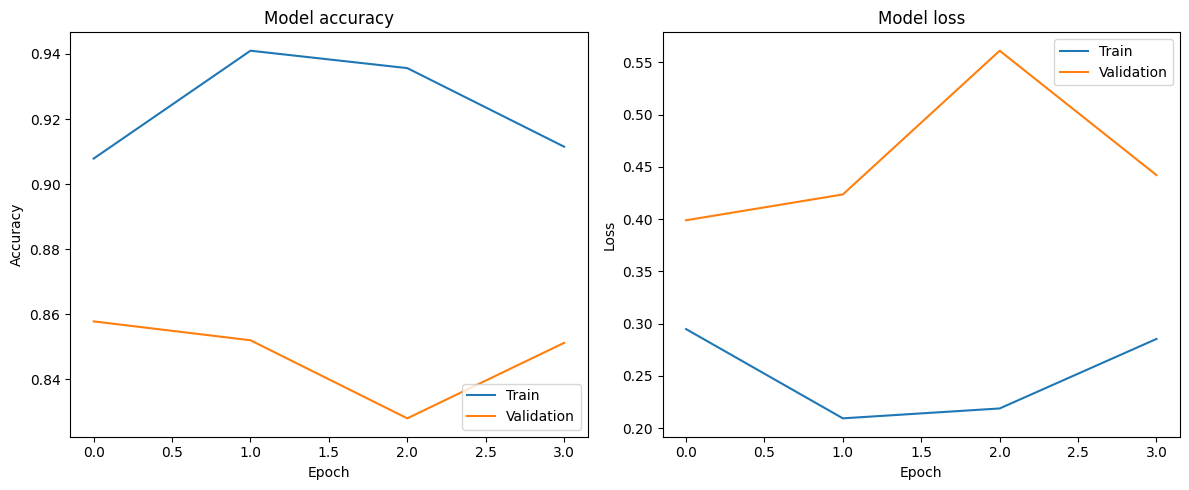

In [19]:
plot_training_history(history)


Evaluating model...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8534 - loss: 0.3931
Test Loss: 0.4088
Test Accuracy: 0.8450
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      2500
           1       0.82      0.88      0.85      2500

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.84      5000
weighted avg       0.85      0.84      0.84      5000



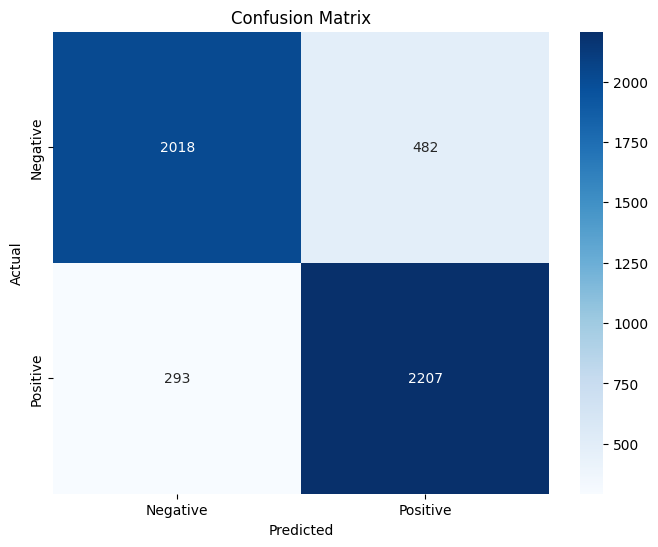

In [21]:
metrics = evaluate_model(model, X_test, y_test)

In [22]:
sample_texts = [
    "This movie was amazing! I loved every minute of it.",
    "What a terrible waste of time. The acting was horrible."
]
predictions = predict_sentiment(sample_texts, model, tokenizer, MAX_LEN)

for pred in predictions:
    print(f"Text: {pred['text'][:50]}...")
    print(f"Sentiment: {pred['sentiment']} (Confidence: {pred['confidence']:.4f})")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Text: This movie was amazing! I loved every minute of it...
Sentiment: Positive (Confidence: 0.9438)

Text: What a terrible waste of time. The acting was horr...
Sentiment: Negative (Confidence: 0.9409)



In [23]:
save_model_artifacts(model, tokenizer)

Model saved to sentiment_model/model.h5
Tokenizer saved to sentiment_model/tokenizer.pickle
